In [1]:
import torch
import torch.nn as nn
import timm
from tqdm import tqdm
import methods
import os
from astropy.io import fits
from astropy.wcs import WCS, utils
from astropy.coordinates import SkyCoord
import matplotlib.pyplot as plt
import numpy as np
import json
from io import BytesIO
import requests
from copy import deepcopy
from astropy.nddata import Cutout2D
from torch.nn.utils.rnn import pad_sequence
from itertools import chain
import seaborn as sns


In [128]:
import torch.nn as nn

class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # latent space size
        hidden_dims = [16, 32, 64] # num of filters in layers
        modules = []
        in_channels = 1 # initial value of channels
        for h_dim in hidden_dims: # conv layers
            modules.append(
                nn.Sequential(
                    nn.Conv2d(                    
                        in_channels=in_channels, # num of input channels 
                        out_channels=h_dim, # num of output channels 
                        kernel_size=3, 
                        stride=2, # convolution kernel step
                        padding=1, # save shape
                        bias=False,
                    ),
                    nn.BatchNorm2d(h_dim),  
                    nn.LeakyReLU(), 
                )
            )
            in_channels = h_dim # changing number of input channels for next iteration

        #modules.append(
        #    nn.Sequential(
        #        nn.Conv2d(in_channels=256, out_channels=512, kernel_size=1, bias=False), # changing the kernel size, because  size of the array (2*2)
        #        nn.BatchNorm2d(512),
        #        nn.LeakyReLU(),
        #    )
        #)
        modules.append(nn.Flatten()) # to vector, size 512 * 2*2 = 2048
        modules.append(nn.Linear(hidden_dims[-1] * 4 * 4, latent_dim)) 

        self.encoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.encoder(x)
        return x


class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()

        hidden_dims = [64, 32, 16] # num of filters in layers
        self.linear = nn.Linear(in_features=latent_dim, out_features=hidden_dims[0]*4*4) 

        modules = []
        for i in range(len(hidden_dims) - 1): # define ConvTransopse layers
            modules.append(
                nn.Sequential(
                    nn.ConvTranspose2d(
                        in_channels=hidden_dims[i],
                        out_channels=hidden_dims[i + 1],
                        kernel_size=3,
                        stride=2,
                        padding=1,
                        output_padding=1,
                        bias=False,
                    ),
                    nn.BatchNorm2d(hidden_dims[i + 1]),
                    nn.LeakyReLU(),
                )
            )

        modules.append(
            nn.Sequential(
                nn.ConvTranspose2d(
                    in_channels=hidden_dims[-1],
                    out_channels=hidden_dims[-1],
                    kernel_size=3,
                    stride=2,
                    padding=1,
                    output_padding=1,
                    bias=False,
                ),
                nn.BatchNorm2d(hidden_dims[-1]),
                nn.LeakyReLU(),
                nn.Conv2d(in_channels=hidden_dims[-1], out_channels=1, kernel_size=7, padding=1),
                #nn.Sigmoid(),
            )
        )

        self.decoder = nn.Sequential(*modules)

    def forward(self, x):
        x = self.linear(x) # from latents space to Linear 
        x = x.view(-1, 64, 4, 4) # reshape
        x = self.decoder(x) # reconstruction
        return x

In [162]:
class EncoderLin(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim # latent space size
        self.encoder = nn.Sequential(nn.Flatten(),
                                    nn.Linear(784, 600),
                                    #nn.BatchNorm1d(600),
                                    nn.ReLU(),
                                    
                                    nn.Linear(600, 500),
                                    #nn.BatchNorm1d(500),
                                    nn.ReLU(),
                                    
                                    nn.Linear(500, 400),
                                    #nn.BatchNorm1d(400),
                                    nn.ReLU(),
                                     
                                    nn.Linear(400, 300),
                                    #nn.BatchNorm1d(300),
                                    nn.ReLU(),
                                    
                                    nn.Linear(300, 200),
                                    #nn.BatchNorm1d(200),
                                    nn.ReLU(),
                                    
                                    nn.Linear(200, latent_dim),
                                    #nn.BatchNorm1d(latent_dim),
                                    nn.ReLU(),
                                    )

    def forward(self, x):
        x = self.encoder(x)
        return x


class DecoderLin(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
    
        self.decoder = nn.Sequential(nn.Linear(latent_dim, 200),
                                    #nn.BatchNorm1d(200),
                                    nn.ReLU(),
                                    
                                    nn.Linear(200, 300),
                                    #nn.BatchNorm1d(300),
                                    nn.ReLU(),
                                    
                                    nn.Linear(300, 400),
                                    #nn.BatchNorm1d(400),
                                    nn.ReLU(),
                                    
                                    nn.Linear(400, 500),
                                    #nn.BatchNorm1d(500),
                                    nn.ReLU(),
                                    
                                    nn.Linear(500, 600),
                                    #nn.BatchNorm1d(600),
                                    nn.ReLU(),
                                    
                                    nn.Linear(600, 784),
                                    #nn.BatchNorm1d(784),
                                    nn.ReLU(),
                                    
                                    )

    def forward(self, x):
        x = self.decoder(x) # reconstruction
        x = x.view(-1, 1, 28, 28)
        return x
    

    
    
class VAEEncoderLin(EncoderLin):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0: # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_dim)


In [43]:
import torch.nn.functional as F

'''
Function to train model, parameters: 
  enc - encoder
  dec - decoder
  loader - loader of data
  optimizer - optimizer
  single_pass_handler - return reconstructed image, use for loss 
  loss_handler - loss function 
  epoch - num of epochs
  log_interval - output interval
'''

def train(
    enc,
    dec,
    dataset,
    optimizer,
    single_pass_handler,
    loss_handler,
    epoch,
    log_interval=500,
):

    perm = torch.randperm(dataset.shape[0])
    for batch_idx in range(dataset.shape[0] // 128):
        data = dataset[perm][batch_idx*128:(batch_idx+1)*128]
        batch_size = data.size(0)
        optimizer.zero_grad()
        data = data.to(device)

        latent, output = single_pass_handler(encoder, decoder, data) # reconstructed image from decoder 

        loss = loss_handler(data, output, latent) # compute loss
        loss.backward()
        optimizer.step()
        if batch_idx % log_interval == 0:
            print(
                "Train Epoch: {} [{}/{} ({:.0f}%)]".format(
                    epoch,
                    batch_idx * data.shape[0],
                    dataset.shape[0],
                    100.0 * batch_idx / (dataset.shape[0] // 128),
                ).ljust(40), 
                "Loss: {:.6f}".format(loss.item())
            )


In [176]:
torch.manual_seed(42)

class VAEEncoder(Encoder):
    def __init__(self, latent_dim):
        if latent_dim % 2 != 0: # check for the parity of the latent space
            raise Exception("Latent size for VAEEncoder must be even")
        super().__init__(latent_dim)


def vae_split(latent):
    size = latent.shape[1] // 2 # divide the latent representation into mu and log_var
    mu = latent[:, :size] 
    log_var = latent[:, size:]  
    return mu, log_var


def vae_reparametrize(mu, log_var): 
    sigma = torch.exp(0.5 * log_var) 
    z = torch.randn(mu.shape[0], mu.shape[1]).to(device) 
    return z * sigma + mu 


def vae_pass_handler(encoder, decoder, data, *args, **kwargs): 
    latent = encoder(data) 
    mu, log_var = vae_split(latent) 
    sample = vae_reparametrize(mu, log_var) 
    recon = decoder(sample)
    return latent, recon


def kld_loss(mu, log_var): 
    var = log_var.exp()
    kl_loss = torch.mean(-0.5 * torch.sum(1 + log_var - mu ** 2 - var, dim=1), dim=0)
    return kl_loss


class LogCoshLoss(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, y_t, y_prime_t):
        ey_t = y_t - y_prime_t
        return torch.mean(torch.log(torch.cosh(ey_t + 1e-12)))



def vae_loss_handler(data, recons, latent, kld_weight=0.01, *args, **kwargs):
    mu, log_var = vae_split(latent)
    kl_loss = kld_loss(mu, log_var)
    return kld_weight * kl_loss + LogCoshLoss()(recons, data) #F.mse_loss(recons, data) 

In [94]:
'''
Function return transforms results to numpy for visualization 

encoder - encoder
decoder - decoder
loader - loader of data
single_pass_handler - return latent and reconstruction transform
return_real - return original images, True/False, default = True
return_recon - return transformed image from decoder, True/False, default = True
return_latent - return latent representation from encoder, True/False, default = True
return_labels - return labels, True/False, default = True
'''
def run_eval(
    encoder,
    decoder,
    imgs,
    imgs_labels,
    single_pass_handler,
    return_real=True,
    return_recon=True,
    return_latent=True,
    return_labels=True,
):

    if return_real:
        real = []
    if return_recon:
        reconstr = []
    if return_latent:
        latent = []
    if return_labels:
        labels = []
    with torch.no_grad():
        for batch_idx in range(imgs.shape[0] // 128):
            data, label = imgs[batch_idx*128:(batch_idx+1)*128], imgs_labels[batch_idx*128:(batch_idx+1)*128]
            if return_labels:
                labels.append(label.numpy())
            if return_real:
                real.append(data.numpy())
         
            data = data.to(device)
            label = label.to(device)
            rep, rec = single_pass_handler(encoder, decoder, data, label)
            
            if return_latent:
                latent.append(rep.cpu().numpy())
            if return_recon:
                reconstr.append(rec.cpu().numpy())

    result = {}
    if return_real:
        real = np.concatenate(real)
        result["real"] = real.squeeze()
    if return_latent:
        latent = np.concatenate(latent)
        result["latent"] = latent
    if return_recon:
        reconstr = np.concatenate(reconstr)
        result["reconstr"] = reconstr.squeeze()
    if return_labels:
        labels = np.concatenate(labels)
        result["labels"] = labels
    return result

In [71]:
def plot_manifold(latent_r, labels=None, alpha=0.9, title=None):
    plt.figure(figsize=(10, 10))
    if labels is None:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], cmap="tab10", alpha=alpha)
        if title:
            plt.title(title)
    else:
        plt.scatter(latent_r[:, 0], latent_r[:, 1], c=labels, cmap="tab10", alpha=alpha)
        plt.colorbar()
        if title:
            plt.title(title)
    plt.show()





def plot_imgs(*args, img_size=28, name=None, single_size=2): #, invert_colors=True
    args = [x.squeeze() for x in args]
    n = min([x.shape[0] for x in args])
    figure = np.ones(((img_size + 1) * len(args) + 1, (img_size + 1) * n + 1))

    for i in range(n):
        for j in range(len(args)):
            figure[
                j * img_size + (j + 1): (j + 1) * img_size + (j + 1),
                i * img_size + (i + 1) : (i + 1) * img_size + (i + 1),
            ] = args[j][i].squeeze()

    #if invert_colors:
    #    figure = 1 - figure

    plt.figure(figsize=(single_size * n, single_size * len(args)))

    plt.imshow(figure, cmap="Greys_r", clim=(0, 1))

    plt.grid(False)
    ax = plt.gca()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    if name is not None:
        plt.savefig(name)
    plt.show()

In [14]:
def check_if_r(oid):
    bands = {'1':'g', '2':'r', '3':'i'}
    str_oid = str(oid)
    if len(str_oid) != 15:
        return True if bands[str_oid[4]]=='r' else False

    else:
        return True if bands[str_oid[3]]=='r' else False

#get oids and tags (in r filter) from json
def get_only_r_oids(filepath):
    file = open(filepath)
    obj_list = json.load(file)
    file.close()

    oids = []
    tags = []
    for data in obj_list:
        if check_if_r(data['oid']):
            oids.append(data['oid'])
            tags.append(data['tags'])

    targets = [] # 1-artefact,  0-transient
    for tag_list in tags:
        if 'artefact' in tag_list:
            targets.append(1)
        else:
            targets.append(0)
    
    return oids, targets
####################################################


oids, targets = get_only_r_oids('akb.ztf.snad.space.json')

In [7]:
obj_labels = targets[:50]
imgs_labels = torch.zeros(1)
imgs = torch.zeros(1,28,28)
for i, oid in enumerate(oids[:50]):
    temp = methods.get_img_stack(oid)
    imgs = torch.vstack((imgs, temp))
    imgs_labels = torch.hstack((imgs_labels, torch.full([temp.shape[0]], obj_labels[i])))


In [8]:
imgs = imgs[1:].view(-1, 1, 28, 28).float()
imgs_labels = imgs_labels[1:].long()

In [59]:
test_obj_labels = targets[50:60]
y_test = torch.zeros(1)
x_test = torch.zeros(1,28,28)
for i, oid in enumerate(oids[50:60]):
    temp = methods.get_img_stack(oid)
    x_test = torch.vstack((x_test, temp))
    y_test = torch.hstack((y_test, torch.full([temp.shape[0]], test_obj_labels[i])))

x_test = x_test[1:].view(-1, 1, 28, 28).float()
y_test = y_test[1:].long()

In [177]:
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

latent_dim = 64

learning_rate = 1e-4
encoder = VAEEncoderLin(latent_dim=latent_dim * 2)
decoder = DecoderLin(latent_dim=latent_dim)


encoder = encoder.to(device)
decoder = decoder.to(device)

optimizer = torch.optim.Adam(
    chain(encoder.parameters(), decoder.parameters()), lr=learning_rate
)
for i in range(1, 11):
    train(
        enc=encoder,
        dec=decoder,
        optimizer=optimizer,
        dataset=imgs,
        epoch=i,
        single_pass_handler=vae_pass_handler,
        loss_handler=vae_loss_handler,
        log_interval=30,
    )

Train Epoch: 1 [0/17535 (0%)]            Loss: 0.053884
Train Epoch: 1 [3840/17535 (22%)]        Loss: 0.014680
Train Epoch: 1 [7680/17535 (44%)]        Loss: 0.013486
Train Epoch: 1 [11520/17535 (66%)]       Loss: 0.012165
Train Epoch: 1 [15360/17535 (88%)]       Loss: 0.013842
Train Epoch: 2 [0/17535 (0%)]            Loss: 0.011705
Train Epoch: 2 [3840/17535 (22%)]        Loss: 0.011836
Train Epoch: 2 [7680/17535 (44%)]        Loss: 0.014742
Train Epoch: 2 [11520/17535 (66%)]       Loss: 0.015304
Train Epoch: 2 [15360/17535 (88%)]       Loss: 0.008437
Train Epoch: 3 [0/17535 (0%)]            Loss: 0.011261
Train Epoch: 3 [3840/17535 (22%)]        Loss: 0.013721
Train Epoch: 3 [7680/17535 (44%)]        Loss: 0.015008
Train Epoch: 3 [11520/17535 (66%)]       Loss: 0.013077
Train Epoch: 3 [15360/17535 (88%)]       Loss: 0.015573
Train Epoch: 4 [0/17535 (0%)]            Loss: 0.012889
Train Epoch: 4 [3840/17535 (22%)]        Loss: 0.013313
Train Epoch: 4 [7680/17535 (44%)]        Loss: 0

In [178]:
encoder = encoder.eval()
decoder = decoder.eval()

In [179]:
run_res = run_eval(encoder, decoder, x_test, y_test, vae_pass_handler)

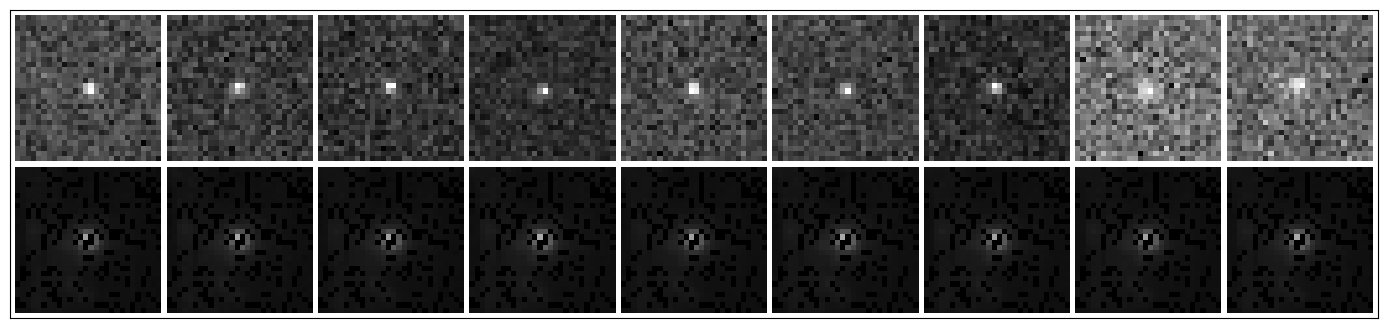

In [180]:
plot_imgs(run_res['real'][0:9], run_res['reconstr'][0:9])

In [181]:
run_res = run_eval(encoder, decoder, imgs[128*2:128*3], imgs_labels[128*2:128*3], vae_pass_handler)

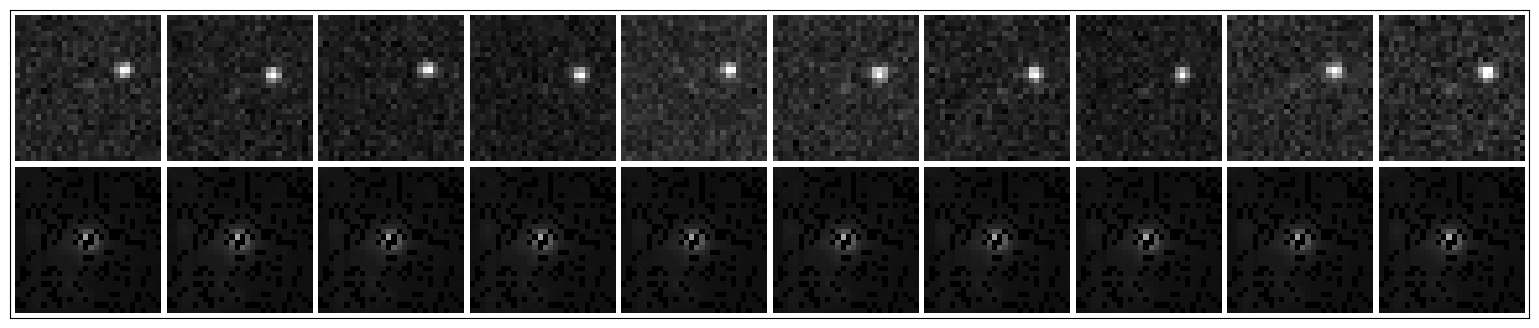

In [182]:
plot_imgs(run_res['real'][10:20], run_res['reconstr'][10:20])